In [1]:
import pandas as pd
import pymysql
import getpass
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib - A gentle introduction

### Get some olist data

```sql
SELECT
    o.order_purchase_timestamp,
    o.order_status,
    o.order_id,
    oi.order_item_id,
    s.seller_id,
    s.seller_state,
    pcnt.product_category_name_english
FROM olist.order_items oi
    INNER JOIN olist.orders o
    ON oi.order_id = o.order_id
    INNER JOIN olist.sellers s
    ON oi.seller_id = s.seller_id
    INNER JOIN olist.products p
    ON oi.product_id = p.product_id
    LEFT JOIN olist.product_category_name_translation pcnt
    ON p.product_category_name = pcnt.product_category_name
    ```
    
This took too long to run in MySQL. Rewrite it to pandas.

In [3]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=getpass.getpass(),
                       db="olist")

········


In [5]:
type("hello") == str

True

In [6]:
# create function that takes a table name and returns the entire table from mysql
def read_sql_table(table_name, conn):
    # if table_name is a string, return the table as a DataFrame
    if type(table_name) == str:
        return pd.read_sql(f"SELECT * FROM {table_name};", conn)

    # if table_name is a list, return all tables as a list of DataFrames
    elif type(table_name) == list:
        return [pd.read_sql(f"SELECT * FROM {table};", conn) for table in table_name]

In [8]:
#order_items = read_sql_table("order_items", conn)
#orders = read_sql_table("orders", conn)
# instead of running a dedicated row for each table, we can modify the function to take a list

In [12]:
a, b = [1,2]

In [13]:
print(a)
print(b)

1
2


In [7]:
tables = ["order_items", "orders", "sellers", "products", "product_category_name_translation"]

order_items, orders, sellers, products, product_category_name_translation = read_sql_table(tables, conn)

In [ ]:
read_sql_table(tables, conn)

In [10]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


```sql
SELECT
    o.order_purchase_timestamp,
    o.order_status,
    o.order_id,
    oi.order_item_id,
    s.seller_id,
    s.seller_state,
    pcnt.product_category_name_english
FROM olist.order_items oi
    INNER JOIN olist.orders o
    ON oi.order_id = o.order_id
    INNER JOIN olist.sellers s
    ON oi.seller_id = s.seller_id
    INNER JOIN olist.products p
    ON oi.product_id = p.product_id
    LEFT JOIN olist.product_category_name_translation pcnt
    ON p.product_category_name = pcnt.product_category_name
    ```

In [17]:
df = (order_items
      .merge(orders, on="order_id")
      .merge(sellers, on="seller_id")
      .merge(products, on="product_id")
      .merge(product_category_name_translation, how="left", on="product_category_name"))

df = df[["order_purchase_timestamp", 
         "order_status", 
         "order_id", 
         "order_item_id", 
         "seller_id", 
         "seller_state", 
         "product_category_name_english",
         "price"]]

In [18]:
df.head()

,order_purchase_timestamp,order_status,order_id,order_item_id,seller_id,seller_state,product_category_name_english,price
0,2017-09-13 08:59:02,delivered,00010242fe8c5a6d1ba2dd792cb16214,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9
1,2017-06-28 11:52:20,delivered,130898c0987d1801452a8ed92a670612,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,55.9
2,2018-05-18 10:25:53,delivered,532ed5e14e24ae1f0d735b91524b98b9,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,64.9
3,2017-08-01 18:38:42,delivered,6f8c31653edb8c83e1a739408b5ff750,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9
4,2017-08-10 21:48:40,delivered,7d19f4ef4d04461989632411b7e588b9,1,48436dade18ac8b2bce089ec2a041202,SP,cool_stuff\r,58.9


## Monthly revenue

We need a table that looks like this:

| month_id | revenue |
|----------|---------|
| 2018-01  | 123453  |
| 2018-02  | 143566  |
| ... | ... |


1. Truncate `order_purchase_timestamp` to `month_id`

In [25]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"].dt.strftime("%Y-%m-01"))

In [27]:
df = df.rename(columns={"order_purchase_timestamp": "month_id"})

In [32]:
(df
 .loc[df["order_status"] == "delivered"]
 .groupby("month_id")
 .agg({"price": "sum"})
 .reset_index()
 .rename(columns={"price": "revenue"}))

,month_id,revenue
0,2016-09-01,134.97
1,2016-10-01,40325.11
2,2016-12-01,10.90
3,2017-01-01,111798.36
4,2017-02-01,234223.40
5,2017-03-01,359198.85
6,2017-04-01,340669.68
7,2017-05-01,489338.25
8,2017-06-01,421923.37
9,2017-07-01,481604.52


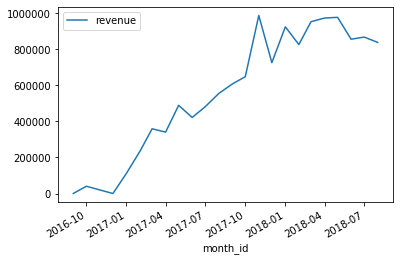

In [44]:
# if you want to plot using pandas methods, don't reset the index. Instead, pandas uses the index as the x-axis
(df
 .loc[df["order_status"] == "delivered"]
 .groupby("month_id")
 .agg({"price": "sum"})
 .rename(columns={"price": "revenue"})).plot();